# NASA Battery Degradation Preprocessing
This notebook loads MATLAB `.mat` files from the NASA Prognostics Center of Excellence dataset (`B0005.mat` to `B0056.mat`), extracts battery degradation curves, normalizes capacity, visualizes degradation trends, and saves the processed data.

In [41]:
# --- 1. Setup ---
import os
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
print("Libraries loaded successfully.")

Libraries loaded successfully.


In [42]:
# --- 2. Define File Paths ---
# Assuming your dataset is in a folder named 'data/nasa_battery'
base_dir = '../data/raw/NASA/'
battery_ids = [f'B{str(i).zfill(4)}.mat' for i in range(5, 57)]  # B0005.mat to B0056.mat

available_files = [f for f in battery_ids if os.path.exists(os.path.join(base_dir, f))]

print(f"Available files ({len(available_files)}):")
print(available_files)

Available files (34):
['B0005.mat', 'B0006.mat', 'B0007.mat', 'B0018.mat', 'B0025.mat', 'B0026.mat', 'B0027.mat', 'B0028.mat', 'B0029.mat', 'B0030.mat', 'B0031.mat', 'B0032.mat', 'B0033.mat', 'B0034.mat', 'B0036.mat', 'B0038.mat', 'B0039.mat', 'B0040.mat', 'B0041.mat', 'B0042.mat', 'B0043.mat', 'B0044.mat', 'B0045.mat', 'B0046.mat', 'B0047.mat', 'B0048.mat', 'B0049.mat', 'B0050.mat', 'B0051.mat', 'B0052.mat', 'B0053.mat', 'B0054.mat', 'B0055.mat', 'B0056.mat']


In [43]:
# --- 3. Function to Extract Battery Data ---
def load_battery_data(filepath):
    try:
        mat = scipy.io.loadmat(filepath)
        print(f"Keys in {filepath}: {mat.keys()}")  # Print keys
        
        # Get the battery ID key (e.g., 'B0005')
        battery_key = [key for key in mat.keys() if not key.startswith('__')][0]
        battery_data = mat[battery_key][0, 0]  # Access struct
        print(f"Fields in {battery_key}: {battery_data.dtype.names}")
        
        all_cycles = []

        # Access 'cycle' field (array of structs)
        cycles = battery_data['cycle'][0]
        print(f"Number of cycles: {len(cycles)}")
        
        for cycle_idx, cycle in enumerate(cycles):
            # Extract cycle type
            cycle_type = cycle['type'][0]
            if isinstance(cycle_type, np.bytes_):
                cycle_type = cycle_type.decode('utf-8')
            
            # We are only interested in 'discharge' cycles for capacity
            if cycle_type.lower() == 'discharge':
                cycle_data = cycle['data'][0]  # Access data struct
                
                # Extract measurements (voltage, current, temp, time)
                # Use .flatten() to ensure 1D arrays, then check if they are non-empty
                voltage = cycle_data['Voltage_measured'][0].flatten() if 'Voltage_measured' in cycle_data.dtype.names else np.array([])
                current = cycle_data['Current_measured'][0].flatten() if 'Current_measured' in cycle_data.dtype.names else np.array([])
                temp = cycle_data['Temperature_measured'][0].flatten() if 'Temperature_measured' in cycle_data.dtype.names else np.array([])
                time = cycle_data['Time'][0].flatten() if 'Time' in cycle_data.dtype.names else np.array([])

                # Safely extract capacity
                capacity_raw = cycle_data['Capacity'][0]  # This is a 1-element array
                # The actual capacity value is inside this array, often as a 2D array
                if capacity_raw.size > 0:
                    # Unpack the value. It's typically a 1x1 array like [[1.55]]
                    try:
                        capacity = float(capacity_raw[0][0])
                    except (IndexError, ValueError):
                        capacity = np.nan
                else:
                    capacity = np.nan

                # Calculate mean values only if arrays are non-empty
                all_cycles.append({
                    'battery_id': os.path.basename(filepath).replace('.mat', ''),
                    'cycle_index': cycle_idx + 1,
                    'voltage': np.mean(voltage) if voltage.size > 0 else np.nan,
                    'current': np.mean(current) if current.size > 0 else np.nan,
                    'temperature': np.mean(temp) if temp.size > 0 else np.nan,
                    'time': (time[-1] - time[0]) if time.size > 1 else 0,
                    'capacity': capacity
                })

        df = pd.DataFrame(all_cycles)
        print(f"✅ Loaded {len(df)} discharge cycles from {filepath}")
        return df

    except Exception as e:
        print(f"❌ Error loading {filepath}: {e}")
        return pd.DataFrame()

# --- 4. Load All Available Batteries ---
base_dir = '../data/raw/NASA'
available_files = [f for f in os.listdir(base_dir) if f.endswith('.mat')]
all_dfs = []

for filename in available_files:
    filepath = os.path.join(base_dir, filename)
    df = load_battery_data(filepath)
    if not df.empty:
        all_dfs.append(df)

# Combine all into one DataFrame
if all_dfs:
    df_battery = pd.concat(all_dfs, ignore_index=True)
    print(f"Total cycles loaded: {len(df_battery)}")
else:
    print("No data loaded. Check file paths or data structure.")
    df_battery = pd.DataFrame()

Keys in ../data/raw/NASA\B0005.mat: dict_keys(['__header__', '__version__', '__globals__', 'B0005'])
Fields in B0005: ('cycle',)
Number of cycles: 616
✅ Loaded 168 discharge cycles from ../data/raw/NASA\B0005.mat
Keys in ../data/raw/NASA\B0006.mat: dict_keys(['__header__', '__version__', '__globals__', 'B0006'])
Fields in B0006: ('cycle',)
Number of cycles: 616
✅ Loaded 168 discharge cycles from ../data/raw/NASA\B0006.mat
Keys in ../data/raw/NASA\B0007.mat: dict_keys(['__header__', '__version__', '__globals__', 'B0007'])
Fields in B0007: ('cycle',)
Number of cycles: 616
✅ Loaded 168 discharge cycles from ../data/raw/NASA\B0007.mat
Keys in ../data/raw/NASA\B0018.mat: dict_keys(['__header__', '__version__', '__globals__', 'B0018'])
Fields in B0018: ('cycle',)
Number of cycles: 319
✅ Loaded 132 discharge cycles from ../data/raw/NASA\B0018.mat
Keys in ../data/raw/NASA\B0025.mat: dict_keys(['__header__', '__version__', '__globals__', 'B0025'])
Fields in B0025: ('cycle',)
Number of cycles: 8

In [44]:
# --- 4. Load All Available Batteries ---
base_dir = '../data/raw/NASA'
available_files = [f for f in os.listdir(base_dir) if f.endswith('.mat')]
all_dfs = []

for filename in available_files:
    filepath = os.path.join(base_dir, filename)
    df = load_battery_data(filepath)
    if not df.empty:
        all_dfs.append(df)

# Combine all into one DataFrame
if all_dfs:
    df_battery = pd.concat(all_dfs, ignore_index=True)
    print(f"Total cycles loaded: {len(df_battery)}")
else:
    print("No data loaded. Check file paths or data structure.")
    df_battery = pd.DataFrame()

Keys in ../data/raw/NASA\B0005.mat: dict_keys(['__header__', '__version__', '__globals__', 'B0005'])
Fields in B0005: ('cycle',)
Number of cycles: 616
✅ Loaded 168 discharge cycles from ../data/raw/NASA\B0005.mat
Keys in ../data/raw/NASA\B0006.mat: dict_keys(['__header__', '__version__', '__globals__', 'B0006'])
Fields in B0006: ('cycle',)
Number of cycles: 616
✅ Loaded 168 discharge cycles from ../data/raw/NASA\B0006.mat
Keys in ../data/raw/NASA\B0007.mat: dict_keys(['__header__', '__version__', '__globals__', 'B0007'])
Fields in B0007: ('cycle',)
Number of cycles: 616
✅ Loaded 168 discharge cycles from ../data/raw/NASA\B0007.mat
Keys in ../data/raw/NASA\B0018.mat: dict_keys(['__header__', '__version__', '__globals__', 'B0018'])
Fields in B0018: ('cycle',)
Number of cycles: 319
✅ Loaded 132 discharge cycles from ../data/raw/NASA\B0018.mat
Keys in ../data/raw/NASA\B0025.mat: dict_keys(['__header__', '__version__', '__globals__', 'B0025'])
Fields in B0025: ('cycle',)
Number of cycles: 8

In [45]:
df_battery.columns.tolist()

['battery_id',
 'cycle_index',
 'voltage',
 'current',
 'temperature',
 'time',
 'capacity']

In [46]:
# First, calculate norm_capacity for each battery
def normalize_capacity(group):
    # Use the first non-NaN capacity as the initial capacity
    initial_capacity = group['capacity'].dropna().iloc[0]
    group['norm_capacity'] = group['capacity'] / initial_capacity
    return group

df_battery = df_battery.groupby('battery_id', group_keys=False).apply(normalize_capacity)

# Now compute RUL
failure_threshold = 0.7

def compute_rul(group):
    # Work with a version of the group that has no NaN in norm_capacity
    valid_group = group.dropna(subset=['norm_capacity'])
    
    # Find the first cycle where norm_capacity <= 0.8
    failed_cycle = valid_group[valid_group['norm_capacity'] <= failure_threshold]['cycle_index'].min()
    
    # If the battery never failed, use the last cycle
    if pd.isna(failed_cycle):
        failed_cycle = valid_group['cycle_index'].max()
    
    # Calculate RUL for every row in the original group
    group['RUL'] = failed_cycle - group['cycle_index']
    return group

# Apply the RUL calculation
df_battery = df_battery.groupby('battery_id', group_keys=False).apply(compute_rul)

# Add the dataset identifier
df_battery['dataset'] = 'NASA'

print("✅ RUL computed for all NASA batteries")

✅ RUL computed for all NASA batteries


C:\Users\mufas\AppData\Local\Temp\ipykernel_16580\4101006375.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_battery = df_battery.groupby('battery_id', group_keys=False).apply(normalize_capacity)
C:\Users\mufas\AppData\Local\Temp\ipykernel_16580\4101006375.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_battery = df_battery.groupby('battery_id', group_keys=False).apply(compute_rul)


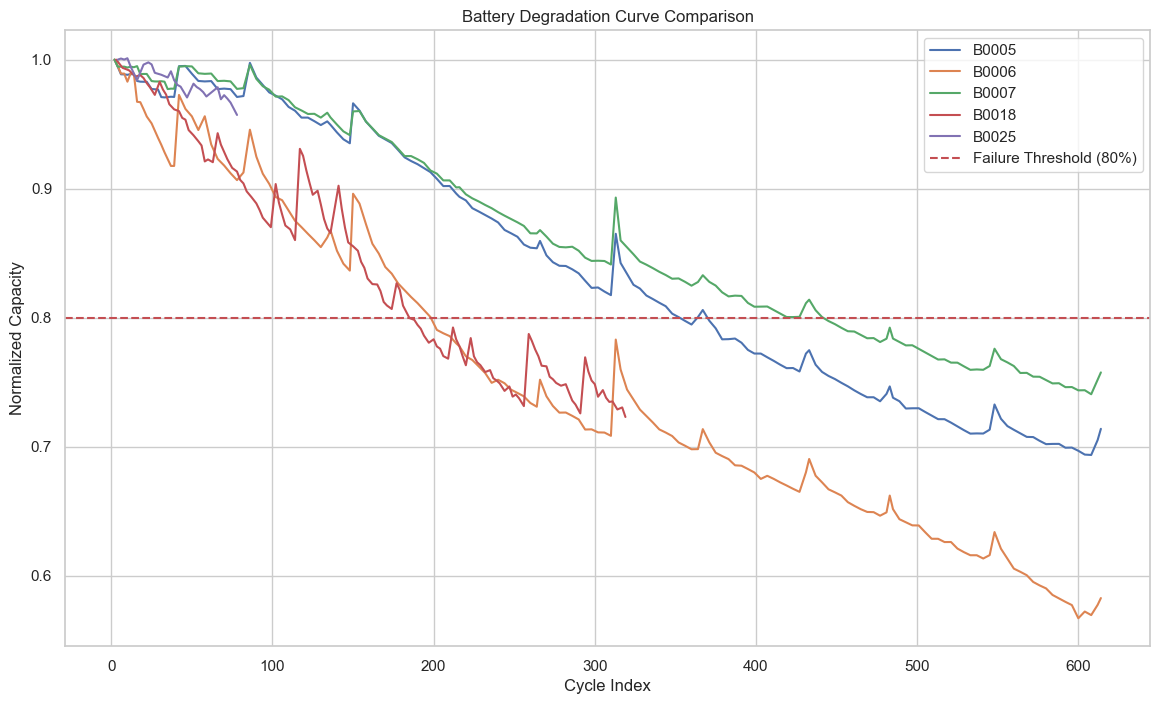

In [47]:
# --- 6. Visualize Degradation Curves ---
plt.figure(figsize=(14, 8))

batteries_to_plot = df_battery['battery_id'].unique()[:5]  # plot first 5 batteries

for bat_id in batteries_to_plot:
    subset = df_battery[df_battery['battery_id'] == bat_id]
    plt.plot(subset['cycle_index'], subset['norm_capacity'], label=bat_id)

plt.axhline(y=0.8, color='r', linestyle='--', label='Failure Threshold (80%)')
plt.xlabel('Cycle Index')
plt.ylabel('Normalized Capacity')
plt.title('Battery Degradation Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
df_battery.columns.tolist()

['battery_id',
 'cycle_index',
 'voltage',
 'current',
 'temperature',
 'time',
 'capacity',
 'norm_capacity',
 'RUL',
 'dataset']

In [49]:
# --- 6. Standardize Column Names (for both notebooks) ---
# For Oxford: Rename and drop unnecessary columns
if 'Battery_ID' in df_battery.columns:
    df_oxford.rename(columns={
        'Battery_ID': 'battery_id',
        'Voltage_V': 'voltage',
        'Current_A': 'current',
        'Temperature_C': 'temperature',
        'Time_s': 'time',
        'Cycle_Index': 'cycle_index',
        'Capacity_Ah': 'capacity',
        'Norm_Capacity': 'norm_capacity',
        'RUL': 'RUL'
    }, inplace=True)
    # Drop columns we don't need
    cols_to_drop = ['Cycle_Type', 'initial_capacity']
    df_battery = df_battery.drop(columns=[col for col in cols_to_drop if col in df_battery.columns])

# For NASA: Ensure the dataset column is present
# df_oxford['dataset'] = 'Oxford' # Add this if it's not already there

# Final list of columns we want
final_columns = ['battery_id', 'cycle_index', 'capacity', 'voltage', 'current', 'temperature', 'time', 'norm_capacity', 'RUL', 'dataset']


df_battery = df_battery[final_columns] # Make sure df_oxford has these columns


In [50]:
df_battery.head()

,battery_id,cycle_index,capacity,voltage,current,temperature,time,norm_capacity,RUL,dataset
0,B0005,2,1.856487,3.529829,-1.818702,32.572328,3690.234,1.000000,590,NASA
1,B0005,4,1.846327,3.537320,-1.817560,32.725235,3672.344,0.994527,588,NASA
2,B0005,6,1.835349,3.543737,-1.816487,32.642862,3651.641,0.988614,586,NASA
3,B0005,8,1.835263,3.543666,-1.825589,32.514876,3631.563,0.988567,584,NASA
4,B0005,10,1.834646,3.542343,-1.826114,32.382349,3629.172,0.988235,582,NASA


In [51]:
# --- 7. Save Processed Data ---
output_path = '../data/processed/nasa_battery_degradation.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_battery.to_csv(output_path, index=False)

print(f"Data saved to {output_path}")

Data saved to ../data/processed/nasa_battery_degradation.csv
